In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda:0'

In [3]:
def model(params, sigma = .1):
    z = np.array(list(params.values()))
    z = z * np.pi
    x = np.sin(z)**2
    return dict(x=x)

In [4]:
def noise(obs, params, sigma = 0.1):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [14]:
zdim=10
params = ["z"+str(i) for i in range(zdim)]
par0 = {k: 0.25 for k in params}
obs0 = noise(model(par0), par0)
obs1=model(par0)

In [13]:
obs0

{'x': array([0.40665641, 0.44751745, 0.49543534, 0.50875185, 0.37775014,
        0.41501781, 0.61583727, 0.51894898, 0.45592899, 0.27893568])}

In [6]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in params})

In [7]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE)

Creating new cache.


the next line is strictly necessary only for "zooming in" -- we will care more about the next step and therefore run with Ninit = 1000, max_rounds = 1.

In [8]:
s.run(Ninit = 1000, max_rounds=1,train_args = dict(lr_schedule = [1e-3, 1e-4]), Nmax=20000)

Simulate:   1%|▏         | 13/1007 [00:00<00:07, 124.60it/s]

NRE ROUND 0
  number of training samples is N = 1000
  adding 1007 new samples to simulator cache.


Simulate: 100%|██████████| 1007/1007 [00:05<00:00, 173.10it/s]


  lr = 0.001
  val loss = 13.86
  val loss = 13.56
  val loss = 11.87
  val loss = 10.57
  val loss = 9.661
  val loss = 9.418
  val loss = 9.184
  val loss = 9.126
  val loss = 8.979
  val loss = 8.811
  lr = 0.0001
  val loss = 8.352
  val loss = 8.35
  val loss = 8.473


focused corner plot for $z_0,z_1$

In [10]:
post = s.gen_2d_marginals(["z0","z1"], train_args = dict(lr_schedule = [1e-3, 3e-4, 1e-4]), N=20000)

Generating marginals for: [('z0',), ('z0', 'z1'), ('z1',)]
Using volume: 1.0


Simulate:   0%|          | 16/18989 [00:00<02:02, 155.41it/s]

  adding 18989 new samples to simulator cache.


Simulate: 100%|██████████| 18989/18989 [01:33<00:00, 202.08it/s]


  lr = 0.001
  val loss = 2.265
  val loss = 2.141
  val loss = 2.099
  val loss = 2.117
  lr = 0.0003
  val loss = 2.054
  val loss = 2.061
  lr = 0.0001
  val loss = 2.015
  val loss = 2.041


In [11]:
samples = post(obs0, 1000000);

In [16]:
#samples for Asimov data
samples1 = post(obs1, 1000000);

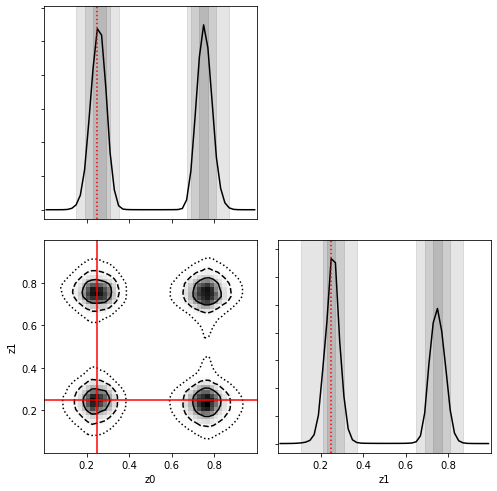

In [17]:
#plot for Asimov
swyft.corner(samples1, ["z0", "z1"], color='k', figsize = (8,8), truth=par0, bins=50)

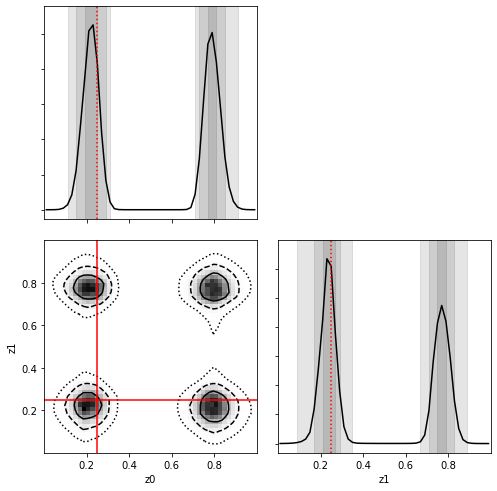

In [18]:
#plot for sample with noise
swyft.corner(samples, ["z0", "z1"], color='k', figsize = (8,8), truth=par0, bins=50)

more detailed fitting of all 1-d marginals

In [19]:
post2 = s.gen_1d_marginals(["z"+str(i) for i in range(zdim)], N=20000)

Generating marginals for: [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)]
Using volume: 1.0
  lr = 0.001
  val loss = 8.351
  val loss = 8.199
  val loss = 8.22
  lr = 0.0003
  val loss = 7.94
  val loss = 7.943
  lr = 0.0001
  val loss = 7.777
  val loss = 7.817


In [20]:
samples2 = post2(obs1, 1000000);

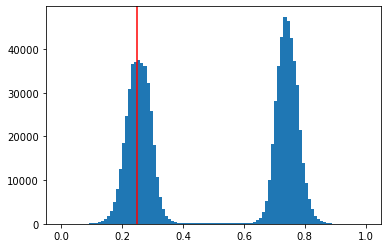

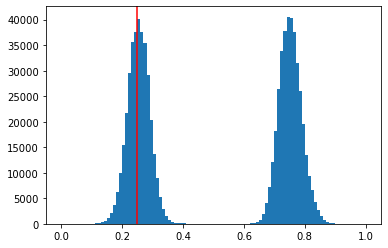

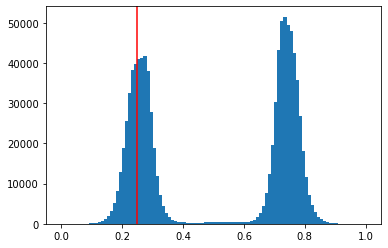

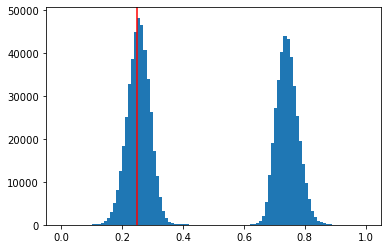

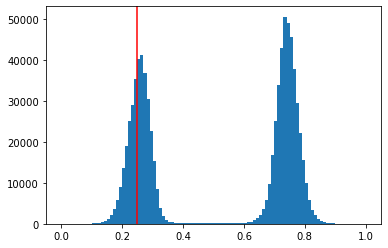

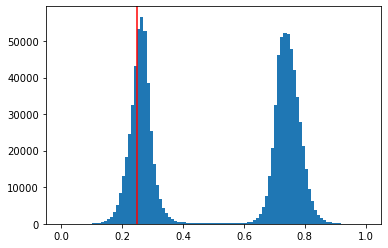

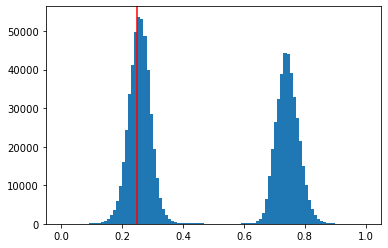

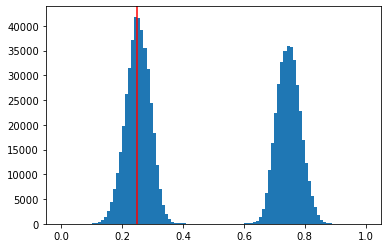

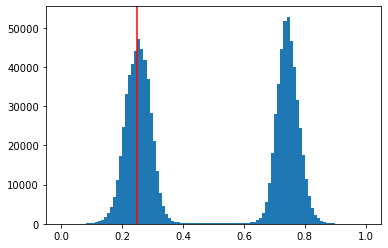

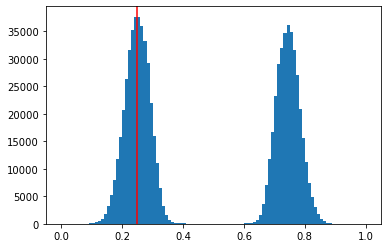

In [27]:
for par in ['z'+str(i) for i in range(10)]:
    plt.figure(figsize=[6,4])
    plt.hist(samples2['params'][par], weights = samples2['weights'][(par,)], bins=100);
    plt.axvline(par0[par],color='r');